# MELANIN-CENTERED SKINCARE RECOMMENDATION SYSTEM

![product.png](images/product.png)


**GROUP MEMBERS**
1. Esther Cheruiyot
2. Brian Githinji
3. Grace Gitau 
4. Maureen Imanene

# Project Summary

This project addresses a significant gap in the skincare industry: **the lack of tailored product recommendations for women of colour**, who often have unique skincare needs such as hyperpigmentation, dryness, and sensitivity. Current recommendation systems tend to generalize recommendations without considering the specific concerns of malanated women, leading to lower customer satisfaction and less effective skincare routines for this demographic.

To bridge this gap, we developed a recommendation system powered by advanced AI techniques, specifically targeting melanin-rich skin. Using a combination of machine learning models, such as content-based filtering (utilizing cosine similarity for ingredient-based similarity), collaborative filtering (using SVD), and sentiment analysis (LSTM model and Sentiment Intensity Analyzer), the system generates personalized product recommendations. Key elements include sentiment classification of reviews, ingredient similarity analysis, and a hybrid recommendation approach to capture and enhance user-product interactions.

The model can provide recommendations based on product similarity, collaborative filtering for user-product interaction, and specific user needs. Moreover, the system offers a user-friendly Streamlit interface, allowing users to input a product name and receive similar product suggestions based on their skincare profile.

By catering specifically to women of color’s skincare needs, **this project aims to increase accessibility to effective skincare solutions and improve customer satisfaction within this underrepresented demographic.**

## Business Problem
Women of color represent a significant demographic in the beauty and skincare industry, yet they face limited access to skincare products tailored to their specific needs, such as hyper- pigmentation, dryness, and sensitivity. Most available recommendation systems overlook the unique skin concerns of women of color, offering general suggestions rather than targeted solutions. This gap impacts consumer satisfaction, as melanated women often struggle to find effective products for their melanin-rich skin. 

This project aims to develop a recommendation system using advanced AI techniques to cater specifically to women’s skincare needs. By integrating machine learning, content- based filtering, collaborative filtering, and sentiment analysis, the system will offer personalized skincare recommendations. Leveraging skin_tone (Author's skin tone (e.g. fair, tan, etc.) as a classification feature, we aim to distinguish and target products that align with melanin-rich skin concerns.

### Objectives
1. Develop a melanin-centered skincare recommendation system using deep learning, tailored for Black women’s unique skin needs.
2. Utilize content-based and collaborative filtering along with sentiment analysis to enhance recommendation accuracy. 
3. Deploy an accessible Streamlit interface for personalized, user-friendly skincare suggestions. 

### Stakeholders
1. *Users*: Black women seeking tailored skincare solutions. 
2. *Skincare Brands*: Companies interested in product insights for melanin-rich skin. 
3. *Healthcare Professionals*: Dermatologists who may use the system as a recommendation tool. 

## Data Understanding:
The dataset was collected via a Python scraper and contains:
- Product Information: Over 8,000 beauty products from the Sephora online store, including product and brand names, prices, ingredients, ratings, and various features. 
- User Reviews: Approximately 1 million reviews across over 2,000 products in the skincare category. These reviews include user appearances, skin types, and review ratings.

The key features include:
- Product Features: `product_id`, `product_name`, `brand_name`, `ingredients`, `rating`, `price_ksh`, `new`, `out_of_stock`, `highlights`. 
- Review Features: `author_id`, `rating`, `review_text`, `skin_type`, `skin_tone`, and
`helpfulness`.

## Metric of Success
### A.Accuracy Metrics:
1. **Precision@k**: 80% (
- This metric evaluates if the **K** recommended items are relevant to users.

2. **Recall@K**: 75%
- This metric evaluates how many relevant items, were successfully captured in the top **K** recommendation.
  
3. **F1 Score**: 0.77
- This metric shows the balance of precision and recall
  
### B.Coverage Metrics:
1. **Hit Rate @5**: 85%
- This mertric determine if users find relevant product in top 5.
  
2. **Normalized Discounted Cumulative Gain (NDCG)**: 90%
- Considers the position of relevant items, rewarding relevant items appearing earlier in the recommendations list.


### STEP 1: DATA LOADING

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS # To visualize text data
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier

from scipy.sparse.linalg import svds

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

In [2]:
# Load the product info and skincare products reviews from Excel files
products = pd.read_csv('data/product_info.xls', encoding = "ISO-8859-1")
reviews = pd.read_csv('data/skincare_products_reviews.xls', encoding = "ISO-8859-1", low_memory=False)

print('Products size:', products.shape)
print('Reviews size:', reviews.shape)

Products size: (8494, 27)
Reviews size: (49977, 19)


In [3]:
# Necessary columns for target analysis
product_columns = [
    'product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 
    'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 
    'ingredients', 'price_usd', 'new', 'out_of_stock', 'highlights', 'primary_category', 
    'secondary_category', 'tertiary_category', 'sephora_exclusive'
]

review_columns = [
    'product_id', 'author_id', 'rating', 'is_recommended', 'helpfulness', 
    'review_text', 'skin_tone', 'skin_type', 'eye_color', 'hair_color', 'submission_time'
]

# Filter columns in each dataset
products_filtered = products[product_columns]
reviews_filtered = reviews[review_columns]

# Merge filtered dataframes on 'product_id'
data = pd.merge(products_filtered, reviews_filtered, on='product_id', how='outer')

# Display merged data info and preview
print('Merged data size:', data.shape)
data.head()

Merged data size: (57367, 30)


,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,author_id,rating_y,is_recommended,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### STEP 2: DATA PRE-PROCESSING

In [4]:
# Checking for duplicates
data.duplicated().sum()

0

In [5]:
# Handling missing values
missing = []
unique = []
types = []
variables = []
count = []

for item in data.columns:
    variables.append(item)
    missing.append(data[item].isnull().sum())
    unique.append(data[item].nunique())
    types.append(data[item].dtypes)
    count.append(len(data[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})
print("Data info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)

Data info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,57367,935,55732
1,helpfulness,float64,57367,1209,20845
2,hair_color,object,57367,7,16241
3,skin_tone,object,57367,14,14591
4,eye_color,object,57367,6,13650
5,highlights,object,57367,4417,13459
6,variation_value,object,57367,2729,11639
7,is_recommended,float64,57367,2,11207
8,skin_type,object,57367,4,11021
9,variation_type,object,57367,7,10229


In [6]:
# Define threshold for missing values (e.g., 50%)
threshold = 0.5

# Calculate the percentage of missing values for each column
output['missing_percentage'] = output['missing'] / output['count']

# List columns with missing values above the threshold
columns_to_drop = output[output['missing_percentage'] > threshold]['variable'].tolist()

# Drop these columns from the data
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print("Dropped columns with over 50% missing values:", columns_to_drop)

Dropped columns with over 50% missing values: ['variation_desc']


In [7]:
# Replace 'notSureST' with 'Not sure' in the 'skin_tone' column
data['skin_tone'].replace('notSureST', 'Not sure', inplace=True)

# Dictionary for numerical columns with median imputation
numerical_impute = {
    'is_recommended': data['is_recommended'].median(),
    'helpfulness': data['helpfulness'].median()
}

# Fill numerical columns with median
for col, median_value in numerical_impute.items():
    data[col].fillna(median_value, inplace=True)

# Dictionary for string-based columns with relevant placeholders
string_impute = {
    'tertiary_category': 'Unknown',
    'secondary_category': 'Unknown',
    'size': 'Unknown',
    'variation_type': 'Unknown',
    'ingredients': 'Not Recorded',
    'variation_value': 'Unknown',
    'highlights': 'No Highlights',
    'rating_x': '0',
    'rating_y': '0',
    'review_text': 'None',
    'skin_tone': 'Not sure',
    'skin_type': 'Not sure',
    'eye_color': 'Unknown',
    'hair_color': 'Unknown',
    'reviews': 'None',
    'author_id': 'Unknown',
    'submission_time': 'Unknown'
}

# Fill string-based columns with placeholders
for col, placeholder in string_impute.items():
    data[col].fillna(placeholder, inplace=True)

# Verify missing values after imputing
print(data.shape)
print(data.isnull().sum())

(57367, 29)
product_id            0
product_name          0
brand_id              0
brand_name            0
loves_count           0
rating_x              0
reviews               0
size                  0
variation_type        0
variation_value       0
ingredients           0
price_usd             0
new                   0
out_of_stock          0
highlights            0
primary_category      0
secondary_category    0
tertiary_category     0
sephora_exclusive     0
author_id             0
rating_y              0
is_recommended        0
helpfulness           0
review_text           0
skin_tone             0
skin_type             0
eye_color             0
hair_color            0
submission_time       0
dtype: int64


In [8]:
# Basic Statistical Overview
data.describe()

,brand_id,loves_count,price_usd,new,out_of_stock,sephora_exclusive,is_recommended,helpfulness
count,57367.000000,5.736700e+04,57367.000000,57367.000000,57367.000000,57367.000000,57367.000000,57367.000000
mean,5675.726655,1.289152e+04,64.580109,0.090052,0.069901,0.285164,0.849792,0.810155
std,1561.273564,2.762395e+04,69.572838,0.286258,0.254982,0.451496,0.357279,0.243031
min,1063.000000,0.000000e+00,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5668.000000,3.758000e+03,26.000000,0.000000,0.000000,0.000000,1.000000,0.800000
50%,6201.000000,7.745000e+03,42.000000,0.000000,0.000000,0.000000,1.000000,0.884615
75%,6353.000000,1.420400e+04,72.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,8020.000000,1.401068e+06,1900.000000,1.000000,1.000000,1.000000,1.000000,1.000000


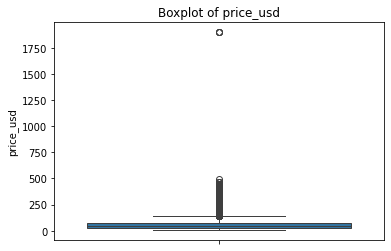

In [9]:
# Identifying Outliers with Boxplots

# Create a list of columns to visualize
columns = ['price_usd']

# Create boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)  # Adjust the layout as needed
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

The boxplot indicates that a number of products are significantly more expensive than the median range, suggesting high-end or luxury skincare items. 
Premium products can be normal in skincare data, especially when catering to diverse skin types and preferences. High-end products often have niche ingredients or technologies, which can drive up prices.

To make a more informed decision, we need to examine the exact values of the prices to see if they’re extreme enough to warrant special handling or if they are within a reasonable range.

In [10]:
# Define a function to identify outliers based on IQR
def find_outliers(data, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define outliers as values outside the range (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return rows with outlier values
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)][[column]]

# Identify outliers for price(ksh) column
price_outliers = find_outliers(data, 'price_usd')
print("Price Outliers:\n", price_outliers)

Price Outliers:
        price_usd
1          195.0
2          195.0
3          195.0
4          195.0
7          195.0
...          ...
57356      148.0
57360      150.0
57361      148.0
57362      150.0
57365      167.0

[5092 rows x 1 columns]


These prices are likely for premium or luxury skincare products, which are typically more expensive due to factors like specialized ingredients, brand positioning, or exclusive benefits. Since some users may prefer high-end products, keeping these premium options in the dataset is valid. We'll proceed by segmenting the products into price tiers (e.g., budget, mid-range, premium).

### FEATURE ENGINEERING

Creating a new 'skin_tone_category' column to classify skin tones as 'melanated' or 'non-melanated'. By grouping skin tones we can focus our analysis and modeling efforts on characteristics most relevant to our target audience, ensuring more accurate and personalized recommendations for melanated skin types.

Additionally, we perform other essential feature engineering tasks, including converting the `submission_time` column from an object data type to a datetime format. This conversion enables effective manipulation of time-related data and analysis of trends. We also create a new `price_ksh` column that converts prices from US dollars to Kenyan Shillings using the exchange rate of 1 USD = 129.27 KSH, facilitating financial analysis in the local currency.

In [11]:
# Lists of skin tones categorized as 'light' or 'dark'
light_skin_tones = ['light', 'fair', 'lightMedium', 'fairLight', 'porcelain', 'olive']
dark_skin_tones = ['mediumTan', 'medium', 'tan', 'rich', 'deep', 'dark']
# Creating a new column 'skin_tone_category' with 'non-melanated' or 'melanated'
data['skin_tone_category'] = data['skin_tone'].apply(lambda x: 'non-melanated' if x in light_skin_tones else 'melanated' if x in dark_skin_tones else 'Not Sure')

# Convert 'submission_time' to datetime format
data['submission_time'] = pd.to_datetime(data['submission_time'], errors='coerce')

# Rename rating_x to rating
data = data.rename(columns={'rating_x': 'rating'})

# Creating a new column 'price_ksh'
data['price_ksh'] = (data['price_usd'] * 129.27)

# Define a function to categorize products by price
def categorize_price(price):
    if price < 5000:
        return 'Budget'
    elif 5000 <= price <= 15000:
        return 'Mid-Range'
    else:
        return 'Premium'

# Apply the function to create a new column 'price_tier'
data['price_tier'] = data['price_ksh'].apply(categorize_price)

# Check the distribution of products in each price tier
print(data['price_tier'].value_counts())

price_tier
Mid-Range    25218
Budget       25210
Premium       6939
Name: count, dtype: int64


In [12]:
# Saving the preprocessed dataset to csv file in our data folder
data.to_csv('data/preprocessed_data.csv')

data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time,skin_tone_category,price_ksh,price_tier
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,Unknown,Unknown,Unknown,...,0.884615,None,Not sure,Not sure,Unknown,Unknown,NaT,Not Sure,4524.45,Budget
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,0.884615,None,Not sure,Not sure,Unknown,Unknown,NaT,Not Sure,25207.65,Premium
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.25,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,0.884615,None,Not sure,Not sure,Unknown,Unknown,NaT,Not Sure,25207.65,Premium
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,0.884615,None,Not sure,Not sure,Unknown,Unknown,NaT,Not Sure,25207.65,Premium
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,0.884615,None,Not sure,Not sure,Unknown,Unknown,NaT,Not Sure,25207.65,Premium


### STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

#### UNIVARIATE ANALYSIS

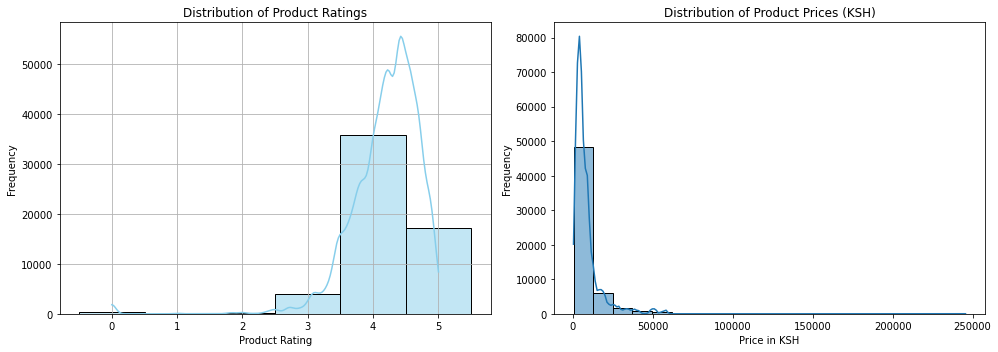

In [13]:
# Distribution of Ratings and Price(ksh)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Visualizing Distribution of Ratings
sns.histplot(data['rating'], bins=20, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Product Ratings')
ax1.set_xlabel('Product Rating')
ax1.set_ylabel('Frequency')
ax1.grid()

# Price Distribution
sns.histplot(data['price_ksh'], bins=20, kde=True, ax=ax2)
ax2.set_title('Distribution of Product Prices (KSH)')
ax2.set_xlabel('Price in KSH')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Histogram 1: Most products seem to have higher ratings, indicating a general satisfaction among customers. The peak around the highest rating suggests that products on this platform are generally well-received, though a minority of products still receive lower scores. This distribution helps set expectations for the customer satisfaction range across products.

Histogram 2: The majority of products fall within a low-to-mid price range, suggesting affordability options across the market. This concentration can aid in identifying budget-friendly options for skincare that may appeal to diverse skin tones.

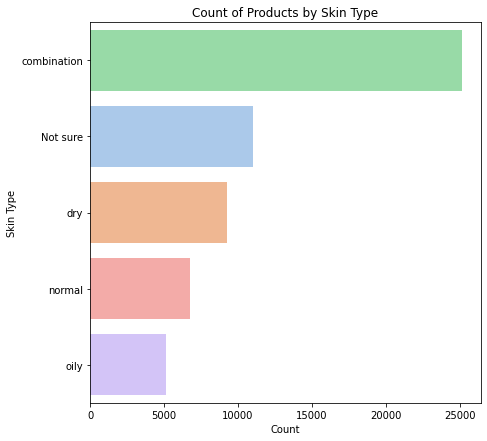

In [14]:
# Count of Products by Skin Type
plt.figure(figsize=(7, 7))
sns.countplot(y='skin_type', data=data, order=data['skin_type'].value_counts().index, palette='pastel', hue='skin_type')
plt.title('Count of Products by Skin Type')
plt.xlabel('Count')
plt.ylabel('Skin Type')
plt.show()

The distribution shows that products labeled for combination skin are the most common, followed by those for dry, normal, and then oily skin. This insight can guide product selection based on prevalent skin types and consumer demand within the Black women demographic.

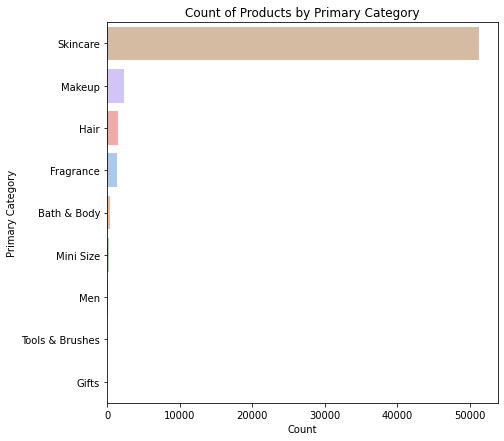

In [15]:
# Count of Products by Skin Type
plt.figure(figsize=(7, 7))
sns.countplot(y='primary_category', data=data, order=data['primary_category'].value_counts().index, palette='pastel', hue='primary_category')
plt.title('Count of Products by Primary Category')
plt.xlabel('Count')
plt.ylabel('Primary Category')
plt.show()

The distribution shows that products labeled for Skincare are the most common.

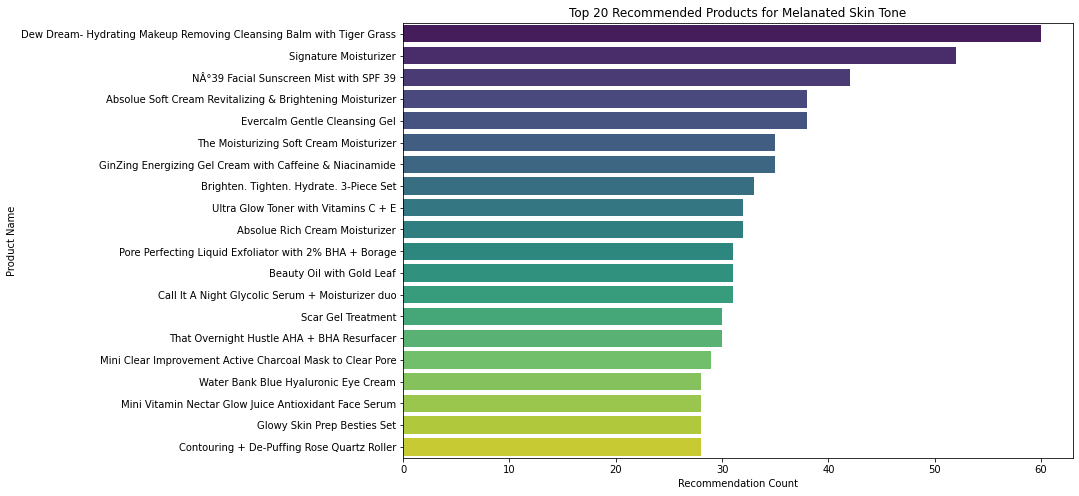

In [16]:
# Top 20 recommended products for melanated skin tone

# Filter data for melanated skin tone and recommended products
melanated_data = data[(data['skin_tone_category'] == 'melanated') & (data['is_recommended'] == 1)]

# Group by product name and count recommendations, selecting the top 20
top_products = melanated_data['product_name'].value_counts().nlargest(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y=top_products.index, x=top_products.values, palette="viridis")
plt.title('Top 20 Recommended Products for Melanated Skin Tone')
plt.xlabel('Recommendation Count')
plt.ylabel('Product Name')
plt.show()

For melanated skin tones, there's a strong emphasis on gentle yet effective skincare products, with the top three recommendations focusing on hydration and sun protection. 

The Dew Dream Cleansing Balm leads the pack with about 55 recommendations, suggesting that gentle makeup removal is a priority for this skin type. The second most recommended product being the Signature Moisturizer, followed by the NA°39 Facial Sunscreen Mist with SPF 39, indicates that maintaining skin hydration and sun protection are crucial concerns for melanated skin. The prevalence of brightening, revitalizing, and gentle products in the top 10 (such as Absolue Soft Cream and Evercalm Gentle Cleansing Gel) suggests that users with melanated skin often seek products that address hyperpigmentation and sensitivity while maintaining skin barrier health. 

The list also includes several treatment-focused products like glycolic serums and exfoliators in the middle to lower rankings, indicating that while these are important, they're secondary to basic skin protection and hydration needs.

#### BIVARIATE ANALYSIS

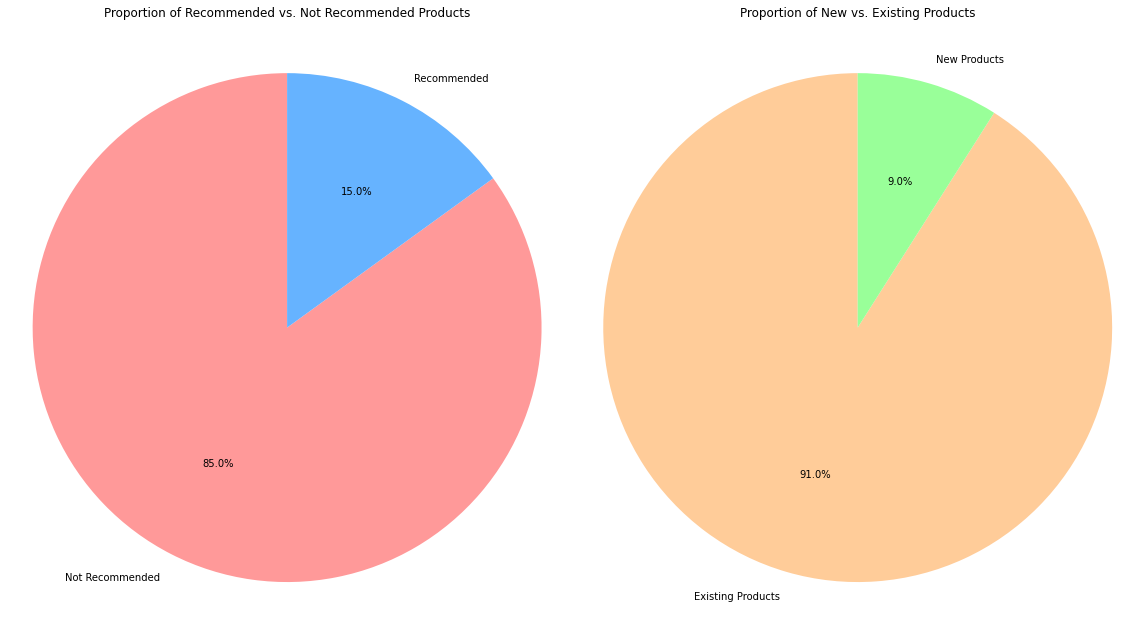

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

# Pie chart for Recommended vs Not Recommended
recommendation_counts = data['is_recommended'].value_counts()
ax1.pie(recommendation_counts, labels=['Not Recommended', 'Recommended'], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B3FF'])
ax1.set_title('Proportion of Recommended vs. Not Recommended Products')
ax1.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Pie chart for New vs Existing Products
new_counts = data['new'].value_counts()
ax2.pie(new_counts, labels=['Existing Products', 'New Products'], autopct='%1.1f%%', startangle=90, colors=['#FFCC99', '#99FF99'])
ax2.set_title('Proportion of New vs. Existing Products')
ax2.axis('equal')

plt.tight_layout()
plt.show()

The **Recommended** pie chart illustrates the percentage of products recommended versus those that are not. A significant portion (85%) of products are not marked as recommended, indicating a possible quality or suitability gap. This could help identify where product performance might fall short or suggest a need for more tailored product options.

The **Products** pie chart shows the balance between new and existing products. The larger percentage of existing products (91%) suggests that the platform maintains a consistent range of products, with newer items being introduced selectively. This distribution can provide insights into the inventory management and refresh rates of the catalog over time.

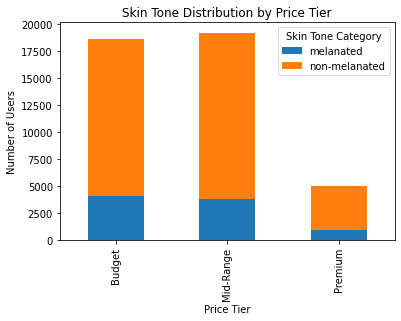

In [18]:
# Filter out 'Not Sure' entries in the 'skin_tone_category' column
filtered_data = data[data['skin_tone_category'] != 'Not Sure']

# Group by 'price_tier' and 'skin_tone_category', and plot the distribution
skin_tone_tier = filtered_data.groupby(['price_tier', 'skin_tone_category']).size().unstack()
skin_tone_tier.plot(kind='bar', stacked=True)
plt.title('Skin Tone Distribution by Price Tier')
plt.xlabel('Price Tier')
plt.ylabel('Number of Users')
plt.legend(title='Skin Tone Category')
plt.show()

There is a noticeable price difference across skin tones. Products for melanated skin tend to have lower average prices, than non-melanated skin tones, highlighting more affordable options specifically formulated or suited for melanated skin. 

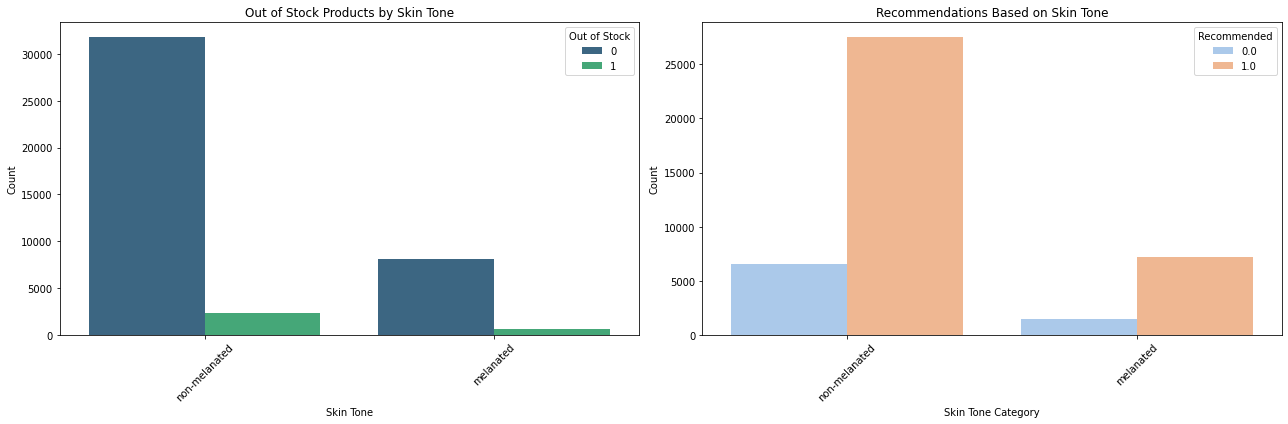

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Out of Stock by Skin Tone
sns.countplot(x='skin_tone_category', hue='out_of_stock', data=filtered_data, palette='viridis', ax=ax1)
ax1.set_title('Out of Stock Products by Skin Tone')
ax1.set_xlabel('Skin Tone')
ax1.set_ylabel('Count')
ax1.legend(title='Out of Stock')
ax1.tick_params(axis='x', rotation=45)

# Recommendations by Skin Tone
sns.countplot(x='skin_tone_category', hue='is_recommended', data=filtered_data, palette='pastel', ax=ax2)
ax2.set_title('Recommendations Based on Skin Tone')
ax2.set_xlabel('Skin Tone Category')
ax2.set_ylabel('Count')
ax2.legend(title='Recommended')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Lighter skin tones show a higher count of both in-stock and out-of-stock products. This contrasts with deep skin tones which have fewer options overall and lower in-stock counts. This discrepancy might indicate a supply gap for these deeper skin tones, which are more likely to face limited product availability.

Products targeting melanated skin tones receive fewer recommendations, suggesting that product options may not fully address the needs or preferences of these individuals.

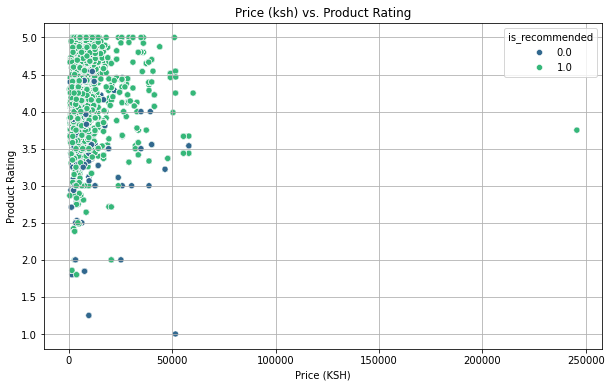

In [20]:
# Correlation between Ratings and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='price_ksh', y='rating', hue='is_recommended', palette='viridis')
plt.title('Price (ksh) vs. Product Rating')
plt.xlabel('Price (KSH)')
plt.ylabel('Product Rating')
plt.grid()
plt.show()

The scatter plot shows the relationship between product price and customer ratings. Although there is no strong correlation, products in the low-to-mid price range tend to receive favorable ratings, suggesting that affordability does not necessarily compromise quality. This insight may encourage users to explore budget-friendly options without sacrificing product satisfaction.

There are more recommended product options for combination and dry skin types across lighter skin tones. This trend highlights a potential focus on lighter tones in product recommendations, which may overlook the unique needs of women of color with deeper skin tones and varied skin types.

#### MULTIVARIATE ANALYSIS

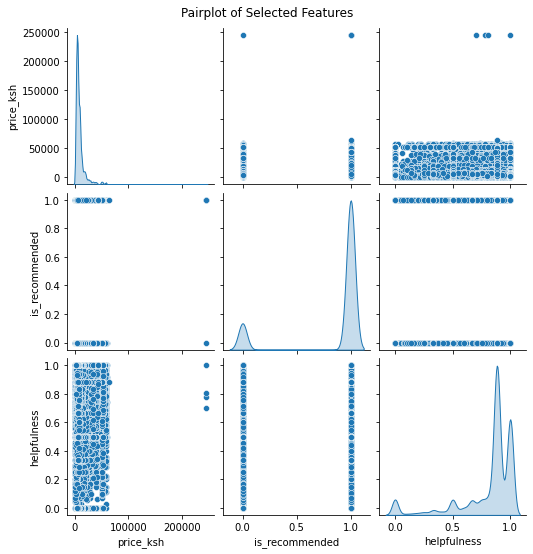

In [21]:
# Pairplot for Selected Features
selected_features = ['rating', 'price_ksh', 'is_recommended', 'helpfulness']
sns.pairplot(data[selected_features], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

The pair plot examines relationships between selected numeric features, such as rating, price(Ksh), and helpfulness. The absence of clear patterns in most pairwise relationships suggests limited linear correlation among these variables. However, this view offers insight into the variability and potential interactions within the data, aiding in feature selection and engineering for subsequent modeling.

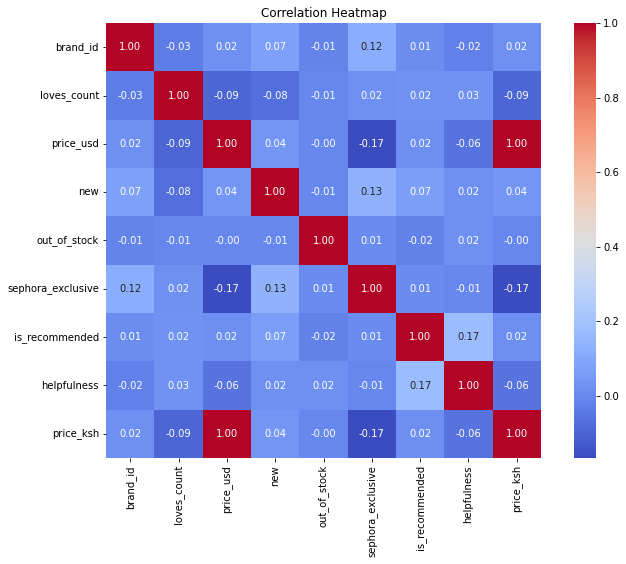

In [22]:
# Heatmap of Correlation Between Numeric Features
plt.figure(figsize=(12, 8))

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Calculate correlation only on numeric columns
correlation = numeric_data.corr()

# Create the heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

Most correlations in this dataset are relatively weak, with values close to zero, suggesting that many variables operate independently of each other. There's a modest positive correlation (0.17) between product helpfulness and whether an item is recommended, suggesting that helpful products tend to receive more recommendations. 

Interestingly, Sephora exclusive products show a slight negative correlation (-0.17) with pricing, indicating that exclusive items aren't necessarily more expensive. The loves_count (measuring customer favorites) shows very weak correlations with other variables, suggesting that a product's popularity isn't strongly tied to its price, availability, or exclusivity status. This pattern of generally weak correlations suggests that success factors in this market are complex and multifaceted, rather than being dominated by any single characteristic.

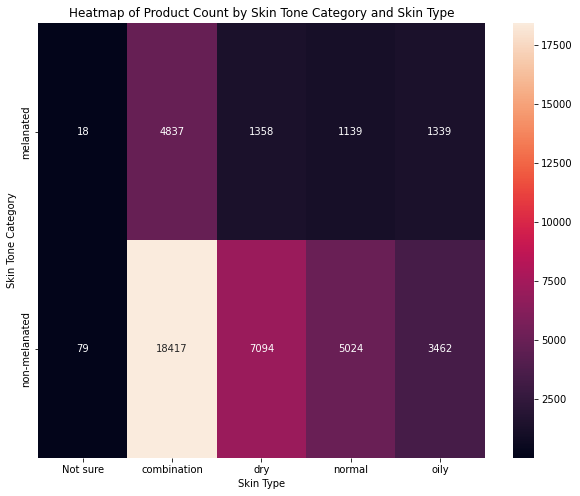

In [23]:
# Create a contingency table
contingency_table = pd.crosstab(index=filtered_data['skin_tone_category'], columns=filtered_data['skin_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title('Heatmap of Product Count by Skin Tone Category and Skin Type')
plt.xlabel('Skin Type')
plt.ylabel('Skin Tone Category')
plt.show()

The heatmap analysis of `skin_type` and `skin_tone_category` highlights important insights that align closely with our objective of providing tailored skincare recommendations for women of color. Our data reveals a concentration of products available for combination and dry skin types, particularly within lighter skin tones. However, there is a notable scarcity of options for deeper skin tones, suggesting that women of color may have fewer product options specifically suited to their needs. This gap underscores the limited market focus on skincare for melanin-rich skin concerns, such as hyperpigmentation, dryness, and sensitivity, which are often more pronounced in deeper skin tones.

These findings directly support our business problem: **many existing recommendation systems fail to provide targeted solutions for melanated women**. The evident lack of specialized options for drier skin in deeper tones emphasizes an opportunity to develop and recommend products that address this unique need. By prioritizing these underserved areas, our recommendation system can significantly enhance satisfaction and efficacy for women of color seeking products that work for their melanin-rich skin.

# STEP 4: MODELING

## 1. SENTIMENT ANALYSIS
We'll use NLTK's Sentiment Intensity Analyzer for sentiment scoring on reviews.The goal being to analyze review_text for sentiment to refine recommendations based on positive feedback.

In [24]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Filter data to include only rows where skin_tone_category is 'melanated'
melanated_data = data[data['skin_tone_category'] == 'melanated']

# Saving the melanated dataset to csv file in our data folder
melanated_data.to_csv('data/melanated_data.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text Preprocessing for Sentiment Analysis

In [25]:
# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function for text cleaning
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing function to the review text
melanated_data['cleaned_review_text'] = melanated_data['review_text'].apply(preprocess_text)

Sentiment Analysis and Classification

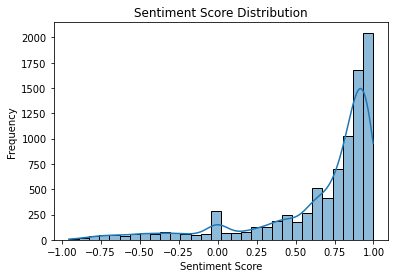

In [26]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
melanated_data['sentiment_score'] = melanated_data['cleaned_review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiments
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

melanated_data['sentiment_category'] = melanated_data['sentiment_score'].apply(classify_sentiment)

# Plot sentiment distribution
sns.histplot(melanated_data['sentiment_score'], kde=True, bins=30)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Most sentiment scores fall between **0.75** and **1.0**, indicating a large proportion of highly favorable reviews. This left-skewed distribution suggests that users with melanated skin tones generally have positive experiences, as evidenced by the high frequency of positive sentiment scores. Overall, this pattern suggests a strong level of satisfaction.

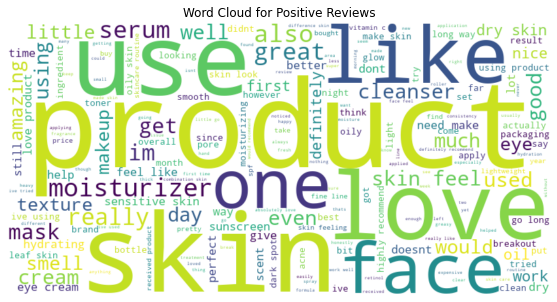

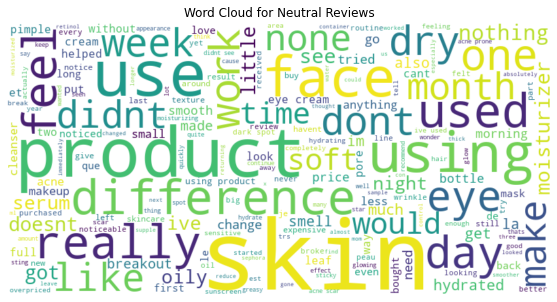

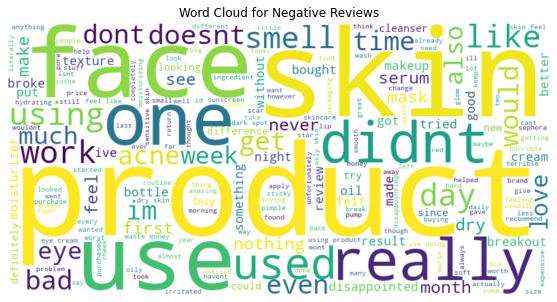

In [27]:
# Generate word clouds for each sentiment category
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = ' '.join(melanated_data[melanated_data['sentiment_category'] == sentiment]['cleaned_review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.show()

Define a function to recommend products based on positive sentiment

In [28]:
def sentiment_based_recommendations(user_id, top_n=5):
    user_reviews = melanated_data[melanated_data['author_id'] == user_id]
    positive_reviews = user_reviews[user_reviews['sentiment_score'] > 0.05]
    return positive_reviews[['product_name', 'skin_type', 'price_ksh']].head(top_n)

# Test with a sample user ID
sample_user_id = '23717108216'
print(sentiment_based_recommendations(sample_user_id , top_n = 5))

                       product_name    skin_type  price_ksh
198  GENIUS Collagen Calming Relief  combination    7497.66


### 3. RECOMMENDATION SYSTEM

Our recommendation system can enhance satisfaction and efficacy for Black women by using data-driven insights from the heatmap to spotlight and prioritize products that meet specific, underserved needs. For instance, with the observed lack of options for dry skin in deeper skin tones, our system can recommend products designed to address hydration and moisture retention, which are critical for managing dryness in melanin-rich skin. Additionally, by identifying gaps for specific skin tones and types, we can curate products with ingredients that target common issues like hyperpigmentation or sensitivity—problems particularly relevant to Black women.

Through advanced filtering, collaborative filtering, and sentiment analysis, our system can highlight well-rated products that align with these needs, even if they’re currently under-marketed for Black women. By promoting these options and analyzing user feedback, the system can gradually refine and adjust recommendations, helping users find products that not only align with their skin type and tone but also actively address their unique skin concerns. This targeted approach leads to more effective skincare routines, as users are less likely to waste time or money on unsuitable products, ultimately increasing both satisfaction and loyalty to our recommendation platform.

### A. Recommender that uses the customer features only to recommend the products

In [29]:
def recommend_products_by_user_features(skin_tone, skin_type, price_tier, 
                                         secondary_category=None, primary_category=None, 
                                         tertiary_category=None, top_n=10):
    # Start with filtering based on skin_tone, skin_type, price_tier
    filtered_data = melanated_data[(melanated_data['skin_tone'] == skin_tone) &
                         (melanated_data['skin_type'] == skin_type) & 
                         (melanated_data['price_tier'] == price_tier)]
    
    # If secondary_category is provided, filter by it
    if secondary_category:
        filtered_data = filtered_data[filtered_data['secondary_category'] == secondary_category]
    
    # If primary_category is provided, filter by it; otherwise, include all primary categories
    if primary_category:
        filtered_data = filtered_data[filtered_data['primary_category'] == primary_category]
    
    # If tertiary_category is provided, filter by it
    if tertiary_category:
        filtered_data = filtered_data[filtered_data['tertiary_category'] == tertiary_category]
    
    # Remove duplicates to ensure uniqueness
    unique_recommendations = filtered_data.drop_duplicates(subset=['product_name']).head(top_n)
    
    return unique_recommendations[['product_name', 'brand_name', 'price_ksh']]

# Sample user features
sample_skin_tone = 'deep'
sample_skin_type = 'dry'
sample_price_tier = 'Budget'
sample_secondary_category = 'Sunscreen'
sample_primary_category = 'Skincare'
sample_tertiary_category = 'Face Sunscreen'

print("Top products for your features:")
print(recommend_products_by_user_features(sample_skin_tone, sample_skin_type, 
                                           sample_price_tier, sample_secondary_category, 
                                           sample_primary_category, sample_tertiary_category))

Top products for your features:
                                            product_name      brand_name  \
6520   Superdefense City Block Broad Spectrum SPF 50 ...        CLINIQUE   
6608   Broad Spectrum SPF 50 Mineral Sunscreen Fluid ...        CLINIQUE   
19295  Invisible Shield Water-Gel Transparent Sunscre...        Glossier   
20254            NÂ°39 Facial Sunscreen Mist with SPF 39           HABIT   
20356            NÂ°38 Facial Sunscreen Mist with SPF 38           HABIT   
53790            Polyglutamic Acid Dewy Sunscreen SPF 30  The INKEY List   

       price_ksh  
6520   4136.6400  
6608   4007.3700  
19295  3231.7500  
20254  3878.1000  
20356  3878.1000  
53790  1937.7573  


### Recommender that uses the highlights to recommend the products

In [30]:
import ast

# Cleaning the higlights values
# Convert strings representing lists into actual lists
def clean_highlights(highlights):
    try:
        # Convert string to list (if the list is represented as a string)
        highlights_list = ast.literal_eval(highlights)
        
        # If highlights is already a list, no need to convert
        if isinstance(highlights_list, list):
            # Remove duplicates by converting to a set, then back to a list
            highlights_list = list(set(highlights_list))
            
            # Standardize terms (example)
            highlights_list = [term.strip().lower() for term in highlights_list]
            
            # Optional: remove extra characters (e.g., " & " should be cleaned to "and")
            highlights_list = [term.replace("&", "and") for term in highlights_list]
        
        return highlights_list
    except:
        # In case of any errors, return an empty list or handle differently
        return []

# Apply the cleaning function to the 'highlights' column
melanated_data['highlights_clean'] = melanated_data['highlights'].apply(clean_highlights)

all_highlights = melanated_data['highlights_clean'].explode().unique()  # Flatten all lists and get unique values
print(all_highlights)

['collagen' 'good for: redness' 'best for dry, combo, normal skin' 'vegan'
 'hypoallergenic' 'good for: acne/blemishes' 'best for combination skin'
 'good for: loss of firmness' 'best for oily, combo, normal skin'
 'good for: dark spots' 'vitamin c' 'good for: anti-aging' 'niacinamide'
 nan 'retinol' 'good for: dullness/uneven texture' 'without parabens'
 'plumping' 'clean at sephora' 'hyaluronic acid' 'good for: pores'
 'hydrating' 'good for: dryness' 'allure 2021 best of beauty award winner'
 'cruelty-free' 'aha/glycolic acid' 'good for: dark circles'
 'salicylic acid' 'clean + planet positive' 'best for dry skin'
 'refill available' 'without sulfates sls and sles' 'alcohol free'
 'volumizing' 'high shine finish' 'fragrance free' 'without phthalates'
 'spf' 'without mineral oil' 'gluten free' 'natural finish'
 'best for oily skin' 'fresh scent' 'radiant finish' 'without silicones'
 'recyclable packaging' 'uv protection' 'light coverage' 'cream formula'
 'oil free' 'allure 2019 best o

In [31]:
def recommend_products_by_highlights(selected_highlights, top_n=10):
    """
    Recommend products based on selected highlights (e.g., 'hydrating', 'anti-aging').
    
    :param selected_highlights: List of highlights the user is interested in (e.g., ['hydrating', 'anti-aging']).
    :param top_n: Number of top products to recommend based on rating or other criteria.
    :return: Top N recommended products as a DataFrame.
    """
    # Convert selected highlights to lowercase to ensure case-insensitive matching
    selected_highlights = [highlight.lower() for highlight in selected_highlights]
    
    # Filter products that contain any of the selected highlights
    filtered_data = melanated_data[melanated_data['highlights_clean'].apply(lambda x: any(highlight in x for highlight in selected_highlights))]
    
    # Remove duplicates to ensure unique product names and take top N
    unique_recommendations = filtered_data.drop_duplicates(subset=['product_name']).head(top_n)
    
    # Return the relevant columns
    return unique_recommendations[['product_name', 'highlights_clean']]

# Sample user input for highlights
selected_highlights = ['hydrating', 'anti-aging', 'fragrance-free']

# Get top 5 recommended products based on highlights
recommended_products = recommend_products_by_highlights(selected_highlights, top_n=5)

# Display the recommendations
print("Top products based on your selected highlights:")
print(recommended_products)

Top products based on your selected highlights:
                                          product_name  \
1129  Vitamin B Serum with 5% Niacinamide and Peptides   
1845                       The Ultimate Soothing Cream   
2101                               The Face Cream Mask   
2229                                       The Essence   
2651                    ZenBubble Bi-Phase Toner Serum   

                                       highlights_clean  
1129  [hyaluronic acid, good for: pores, good for: d...  
1845  [good for: dryness, refill available, good for...  
2101  [good for: dryness, good for: loss of firmness...  
2229  [cruelty-free, good for: pores, salicylic acid...  
2651  [good for: redness, cruelty-free, plumping, hy...  


### B. Content-Based Filtering Model
- We’ll start with a content-based filtering model using TF-IDF on highlights and other product features.The aim is to recommend similar products based on ingredients and product features.

**Text Cleaning**:
Leaving highlights raw preserves essential terms for analysis. This enables targeted NLP method, TF-IDF, to identify key ingredients and supports ingredient-based recommendations. This approach maintains data integrity for future modeling without altering original content.

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Vectorize ingredients and create a cosine similarity matrix
tfidf = TfidfVectorizer(stop_words='english')
ingredients_matrix = tfidf.fit_transform(melanated_data['ingredients'].fillna(''))

# Calculate cosine similarity
content_based_model = cosine_similarity(ingredients_matrix, ingredients_matrix)

# Function to extract top N terms for each ingredient based on TF-IDF score
def get_top_ingredients(tfidf_vector, feature_names, top_n=5):
    sorted_indices = tfidf_vector.argsort()[::-1][:top_n]
    top_terms = [feature_names[i] for i in sorted_indices]
    return ', '.join(top_terms)

# Function to recommend products based on content similarity
def content_based_recommendations(product_name, top_n=5):
    try:
        product_index = melanated_data[melanated_data['product_name'] == product_name].index[0]
    except IndexError:
        print("Product not found in the dataset.")
        return None

    # Calculate similarity scores
    sim_scores = list(enumerate(content_based_model[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Initialize a list to keep track of unique product recommendations
    unique_recommendations = []
    seen_products = set()  # Set to track seen product names

    for score in sim_scores:
        product_idx = score[0]
        product_name_candidate = melanated_data.iloc[product_idx]['product_name']

        # Add to recommendations if not already seen and not the input product
        if product_name_candidate != product_name and product_name_candidate not in seen_products:
            unique_recommendations.append(product_idx)
            seen_products.add(product_name_candidate)
        
        # Stop if we've collected enough recommendations
        if len(unique_recommendations) >= top_n:
            break

    # Get recommended products
    recommendations = melanated_data.iloc[unique_recommendations][['product_name', 'brand_name', 'price_ksh']]

    # Add a column for top ingredients by iterating over the ingredient vectors
    feature_names = tfidf.get_feature_names_out()
    top_ingredients = []
    for index in unique_recommendations:
        row_vector = ingredients_matrix[index].toarray().flatten()
        top_ingredients.append(get_top_ingredients(row_vector, feature_names))
    recommendations['top_ingredients'] = top_ingredients

    return recommendations

# Test the function with a sample product name
sample_product_name = melanated_data['product_name'].iloc[0]
print(f"Since you liked {sample_product_name}, you might also like:")
print(content_based_recommendations(sample_product_name))

Since you liked GENIUS Collagen Calming Relief, you might also like:
                            product_name              brand_name  price_ksh  \
1039   Vitamin A Serum with 0.5% Retinol                 Alpha-H    8402.55   
8376           Beauty Oil with Gold Leaf  Danessa Myricks Beauty    3878.10   
26408   KateCeuticals Total Repair Cream         Kate Somerville   18097.80   
24073  Green Tea Hydrating Cleansing Oil               innisfree    3102.48   
18966  Futuredew Facial Oil-Serum Hybrid                Glossier    3361.02   

                                         top_ingredients  
1039    macadamia, oil, lycopersicum, tomato, ternifolia  
8376                 oil, seed, sead, multiflora, walnut  
26408                    oil, seed, poudre, serica, soie  
24073         oil, utylene, tetraoleate, sorbeth, prunus  
18966  oil, polyglyceryl, pentaoleate, castor, rutaec...  


### C. Collaborative Filtering with SVD
- Now we’ll implement collaborative filtering using SVD to capture latent user-product interactions.The goal is to use Matrix Factorization (SVD) on the user-product interaction data for collaborative recommendations.
- Since most user-product interactions (ratings) are likely sparse (i.e., many users rate only a small subset of products), we'll store this interaction matrix as a sparse matrix. This helps save memory by only storing non-zero values

In [33]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Create User-Product Interaction Matrix
user_product_matrix = melanated_data.pivot_table(index='author_id', columns='product_id', values='rating').fillna(0)

# Apply SVD
svd_model = TruncatedSVD(n_components=20)
latent_matrix = svd_model.fit_transform(user_product_matrix)

# Recommending Top Products for a User
def collaborative_recommendations(user_id, top_n=5):
    # Find the index of the user in the DataFrame
    user_index = melanated_data.index[melanated_data['author_id'] == user_id].tolist()[0]
    # Calculate scores based on the latent matrix
    scores = latent_matrix[user_index].dot(latent_matrix.T)
    # Get the indices of the top recommendations
    top_recommendations = scores.argsort()[-top_n:][::-1]
    
    # Fetch recommended products
    recommended_products = melanated_data.iloc[top_recommendations][['product_name', 'author_id', 'brand_name', 'price_ksh']]
    
    return recommended_products

# Test Recommendation for a Sample User
sample_user_id = melanated_data['author_id'].iloc[0]
print("Collaborative Filtering Recommendations:")
print(collaborative_recommendations(sample_user_id))

Collaborative Filtering Recommendations:
                                            product_name    author_id  \
15061  Active Blast Concentrated Collagen Daily Treat...  36544916142   
7646   Full Spectrum 360Â° Refreshing Water Mist Orga...   6576936327   
18234                        Black Tea Firming Eye Serum    917071182   
24401                         Day Dew Self-Tan Face Mist   9062303633   
25567  Face Stone Nourishing Solid Refillable Facial ...  10086164821   

             brand_name  price_ksh  
15061           FaceGym    8402.55  
7646              COOLA    4653.72  
18234             fresh    9307.44  
24401  Isle of Paradise    3102.48  
25567       Kate McLeod    8790.36  


### Recommendation Evaluation

### SVD-based collaborative filtering model evaluation. ​

Calculate predictions for users in the test set.

1. Re-training the SVD Model on Train Data.
2. Generating predictions for users in the test set based on the trained SVD model.

In [34]:
# Split data into training and testing sets
train_data = melanated_data.sample(frac=0.8, random_state=42)
test_data = melanated_data.drop(train_data.index)

# Ensure that 'rating' column is numeric, converting any strings to NaNs, which we can then handle
train_data['rating'] = pd.to_numeric(train_data['rating'], errors='coerce')

# Replace NaNs (which could have been introduced if there were non-numeric strings) with 0 or a default value
train_data['rating'].fillna(0, inplace=True)

# Create the user-product interaction matrix for training data
train_user_product_matrix = train_data.pivot_table(index='author_id', columns='product_id', values='rating').fillna(0)

# Apply SVD on the training data
svd_model = TruncatedSVD(n_components=20, random_state=42)
latent_matrix_train = svd_model.fit_transform(train_user_product_matrix)

In [35]:
# Define a function to predict rating for a given user-product pair
def predict_rating(user_id, product_id):
    try:
        # Get indices of user and product
        user_index = train_user_product_matrix.index.get_loc(user_id)
        product_index = train_user_product_matrix.columns.get_loc(product_id)
        # Calculate predicted rating by matrix dot product
        return latent_matrix_train[user_index].dot(latent_matrix_train.T[:, product_index])
    except KeyError:
        # Return NaN if user_id or product_id are not in the training set
        return np.nan
    
# Extract true and predicted ratings from the test set
y_true = []
y_pred = []

for row in test_data.itertuples():
    actual_rating = row.rating
    user_id = row.author_id
    product_id = row.product_id
    
    predicted_rating = predict_rating(user_id, product_id)
    
    if not np.isnan(predicted_rating):  # Skip NaN predictions
        y_true.append(actual_rating)
        y_pred.append(predicted_rating)
    
# Calculate RMSE and MAE for test set
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 4.490702978215436
MAE: 4.408723098133908


### Hyperparameter Tuning for our Collaborative model

In [36]:
# Increase the number of components in SVD
def tune_svd_components(num_components=20):
    svd = TruncatedSVD(n_components=num_components)
    latent_matrix = svd.fit_transform(train_user_product_matrix)
    return latent_matrix

# Example of tuning
latent_matrix_trainA = tune_svd_components(num_components=300)

In [37]:
# Define a function to predict rating for a given user-product pair
def predict_rating(user_id, product_id):
    try:
        # Get indices of user and product
        user_index = train_user_product_matrix.index.get_loc(user_id)
        product_index = train_user_product_matrix.columns.get_loc(product_id)
        # Calculate predicted rating by matrix dot product
        return latent_matrix_trainA[user_index].dot(latent_matrix_trainA.T[:, product_index])
    except KeyError:
        # Return NaN if user_id or product_id are not in the training set
        return np.nan
    
# Extract true and predicted ratings from the test set
y_trueA = []
y_predA = []

for row in test_data.itertuples():
    actual_rating = row.rating
    user_id = row.author_id
    product_id = row.product_id
    
    predicted_rating = predict_rating(user_id, product_id)
    
    if not np.isnan(predicted_rating):  # Skip NaN predictions
        y_trueA.append(actual_rating)
        y_predA.append(predicted_rating)
        
# Calculate RMSE and MAE for test set
rmse = np.sqrt(mean_squared_error(y_trueA, y_predA))
mae = mean_absolute_error(y_trueA, y_predA)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 4.5963227270800555
MAE: 4.4737205856624085


- We implement the hybrid recommender system to incorporate a better recommendation system

### D. HYBRID RECOMMENDER SYSTEM

In [38]:
# Hybrid Recommendation
def hybrid_recommendations(product_name, user_id=None, content_weight=0.5, collaborative_weight=0.5, top_n=2):
    content_recs = content_based_recommendations(product_name, top_n * 2)
    if content_recs is None:
        return None

    if user_id is not None:
        collaborative_recs = collaborative_recommendations(user_id, top_n * 2)
    else:
        collaborative_recs = pd.DataFrame(columns=content_recs.columns)  # Empty DataFrame if no user ID

    hybrid_recs = pd.concat([content_recs, collaborative_recs])
    hybrid_recs = hybrid_recs.drop_duplicates().reset_index(drop=True)

    # Compute final weighted recommendation scores
    hybrid_recs['score'] = (content_weight * np.arange(len(hybrid_recs)) +
                            collaborative_weight * np.arange(len(hybrid_recs))[::-1])
    hybrid_recs = hybrid_recs.sort_values('score', ascending=False).head(top_n)

    return hybrid_recs[['product_name', 'author_id', 'brand_name', 'price_ksh', 'top_ingredients']]

sample_product_name = melanated_data['product_name'].iloc[0]
sample_user_id = '11624056853'

print(f"Since you liked '{sample_product_name}', you might also like:")
print(hybrid_recommendations(sample_product_name, sample_user_id))

Since you liked 'GENIUS Collagen Calming Relief', you might also like:
                        product_name author_id              brand_name  \
0  Vitamin A Serum with 0.5% Retinol       NaN                 Alpha-H   
1          Beauty Oil with Gold Leaf       NaN  Danessa Myricks Beauty   

   price_ksh                                   top_ingredients  
0    8402.55  macadamia, oil, lycopersicum, tomato, ternifolia  
1    3878.10               oil, seed, sead, multiflora, walnut  


## Evaluation of Hybrid Recommender System

## A. Accuracy Metrics (Recall@k & Precision@k)

In [39]:
#Finding the actual relevance
# Convert the 'rating' column to numeric values, handling errors if any
melanated_data['rating'] = pd.to_numeric(melanated_data['rating'], errors='coerce')
# Define the threshold
threshold = 3

# Create binary relevance column based on the rating threshold
melanated_data['relevance'] = (melanated_data['rating'] > threshold).astype(int)

# Group by user_id and collect the relevance values
actual_relevance = melanated_data.groupby('author_id')['relevance'].apply(list).tolist()

In [40]:
def precision_at_k(relevance, k):
    relevant = np.sum(relevance[:k])
    return relevant / k

def recall_at_k(relevance, k, total_relevant):
    relevant = np.sum(relevance[:k])
    return relevant / total_relevant if total_relevant > 0 else 0

# Define top-k value
K = 5

# Perform evaluation
precisions = []
recalls = []

for relevance in actual_relevance:
    precision = precision_at_k(relevance, K)
    recall = recall_at_k(relevance, K, sum(relevance))
    precisions.append(precision)
    recalls.append(recall)

# Compute the average precision and recall for the entire dataset
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f"Average Precision@{K}: {average_precision:.2f}")
print(f"Average Recall@{K}: {average_recall:.2f}")

Average Precision@5: 0.24
Average Recall@5: 0.99


## Interpretation:
- **Average Precision@5**: 0.24, meaning that on average, 24% of the items recommended in the top 5 were relevant to users. This suggests that while some relevant items are being recommended, there is still room for improvement in ensuring that more of the top recommendations are relevant.

- **Average Recall@5**: 0.99, indicating that 99% of all relevant items (up to the top 5) are being successfully recommended. This is a high recall value, suggesting that your model is good at covering the items users are interested in.



In [41]:
# Define list of K values to test
K_values = [1, 5, 10, 20]

# Initialize dictionaries to store precision and recall for each K
average_precisions = {}
average_recalls = {}

for K in K_values:
    precisions = []
    recalls = []

    for relevance in actual_relevance:
        precision = precision_at_k(relevance, K)
        recall = recall_at_k(relevance, K, sum(relevance))
        precisions.append(precision)
        recalls.append(recall)

    # Compute the average precision and recall for this K
    average_precisions[K] = np.mean(precisions)
    average_recalls[K] = np.mean(recalls)

# Print results for each K
for K in K_values:
    print(f"Average Precision@{K}: {average_precisions[K]:.2f}")
    print(f"Average Recall@{K}: {average_recalls[K]:.2f}")


Average Precision@1: 0.99
Average Recall@1: 0.92
Average Precision@5: 0.24
Average Recall@5: 0.99
Average Precision@10: 0.12
Average Recall@10: 0.99
Average Precision@20: 0.06
Average Recall@20: 0.99


### Interpretation
1. **High Precision and Recall at *K*=1:**
- **Precision@1** of 0.99 and Recall@1 of 0.92 indicate that the model is very accurate when recommending a single top item. Users are very likely to find a relevant item in the top 1 recommendation.
  
2. **Performance Drops as *𝐾* Increases:**
- Precision drops significantly as **𝐾** increases (e.g., **Precision@5** of 0.24 and **Precision@20** of 0.06). This suggests that as more items are recommended, fewer of them are relevant.


## B.Coverage Metrics
### i. Hit Rate@K

In [42]:
def hit_rate_at_k(relevance, k):
    # Hit Rate is 1 if any relevant item is found in the top-K recommendations
    return int(np.sum(relevance[:k]) > 0)

# Calculate Hit Rate@K for each user's relevance list
hit_rates = [hit_rate_at_k(rel, K) for rel in actual_relevance]

# Compute the overall Hit Rate@K
average_hit_rate = np.mean(hit_rates)
print(f"Hit Rate@{K}: {average_hit_rate:.2f}")

Hit Rate@20: 0.99


In [43]:
# Define the values of K for which you want to calculate Hit Rate
K_values = [1, 5, 10, 20]

# Calculate Hit Rate@K for each value of K
hit_rates_at_k = {}

for k in K_values:
    hit_rates = [hit_rate_at_k(rel, k) for rel in actual_relevance]
    hit_rates_at_k[k] = np.mean(hit_rates)
    print(f"Hit Rate@{k}: {hit_rates_at_k[k]:.2f}")

Hit Rate@1: 0.99
Hit Rate@5: 0.99
Hit Rate@10: 0.99
Hit Rate@20: 0.99


## Interpretation
With a Hit Rate of 0.99 across all values of **𝐾**,the model is consistently recommending at least one relevant item within the top **𝐾** recommendations for almost every user.

##  ii. Normalized Discounted Cumulative Gain (NDCG)

In [44]:
# Define DCG@K
def dcg_at_k(relevance, k):
    # Truncate or pad the relevance list to match the length k
    relevance = np.pad(relevance[:k], (0, max(0, k - len(relevance))), 'constant')
    gains = (2**relevance - 1) / np.log2(np.arange(2, k + 2))
    return np.sum(gains)

# Define NDCG@K
def ndcg_at_k(relevance, k):
    dcg = dcg_at_k(relevance, k)
    ideal_relevance = sorted(relevance, reverse=True)
    ideal_dcg = dcg_at_k(ideal_relevance, k)
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# Define K value
K = 10

# Calculate NDCG@K for each user's relevance list
ndcgs = [ndcg_at_k(rel, K) for rel in actual_relevance]

# Compute the average NDCG@K
average_ndcg = np.mean(ndcgs)
print(f"Average NDCG@{K}: {average_ndcg:.2f}")

Average NDCG@10: 0.99


### Interpretation
- The **NDCG@10:** 0.99 result is excellent, indicating that the ranking provided by your recommendation model closely matches the ideal order, where the most relevant items appear at the top.

### 4. DEEP LEARNING MODEL FOR SENTIMENT PREDICTION


FEATURE SELECTION

In [45]:
# Label encode categorical features
categorical_features = ['brand_name', 'variation_type', 'primary_category', 'secondary_category', 'tertiary_category', 
                        'skin_tone', 'skin_type', 'eye_color', 'hair_color']
for col in categorical_features:
    le = LabelEncoder()
    melanated_data[col] = le.fit_transform(melanated_data[col])

# Handle missing values in numeric features before scaling
numeric_features = ['loves_count', 'rating', 'reviews', 'price_usd', 'helpfulness']

# Replace 'None' or other string non-numeric values with NaN
melanated_data[numeric_features] = melanated_data[numeric_features].replace('None', np.nan)

# Convert columns to numeric (forcing errors to NaN)
melanated_data[numeric_features] = melanated_data[numeric_features].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values (if appropriate)
melanated_data = melanated_data.dropna(subset=numeric_features)

# Scale numeric features
scaler = StandardScaler()
melanated_data[numeric_features] = scaler.fit_transform(melanated_data[numeric_features])

Building a Long-short Term Model (LSTM) for sentiment prediction:

In [46]:
# Sample data
texts = melanated_data['cleaned_review_text'].values
labels = melanated_data['sentiment_category'].values  # Labels (positive, negative, neutral)

# Tokenization
tokenizer = Tokenizer(num_words=10000)  # Top 10,000 words
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

# Encoding labels
le = LabelEncoder()
y = le.fit_transform(labels)

# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))  # Embedding layer
model.add(LSTM(128))  # LSTM layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # Output layer for three classes

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
174/174 [==============================] - 22s 116ms/step - loss: 0.4332 - accuracy: 0.8797 - val_loss: 0.3168 - val_accuracy: 0.8994
Epoch 2/10
174/174 [==============================] - 17s 97ms/step - loss: 0.2611 - accuracy: 0.9056 - val_loss: 0.3112 - val_accuracy: 0.8994
Epoch 3/10
174/174 [==============================] - 19s 107ms/step - loss: 0.1638 - accuracy: 0.9444 - val_loss: 0.4069 - val_accuracy: 0.9051
Epoch 4/10
174/174 [==============================] - 22s 127ms/step - loss: 0.0981 - accuracy: 0.9693 - val_loss: 0.4477 - val_accuracy: 0.8454
Epoch 5/10
174/174 [==============================] - 23s 133ms/step - loss: 0.0657 - accuracy: 0.9788 - val_loss: 0.4873 - val_accuracy: 0.8986
Epoch 6/10
174/174 [==============================] - 21s 123ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.4855 - val_accuracy: 0.8706
Epoch 7/10
174/174 [==============================] - 20s 115ms/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 0.5334 - val_acc

55/55 [==============================] - 2s 39ms/step - loss: 0.7570 - accuracy: 0.8919
Test Accuracy: 0.8918918967247009


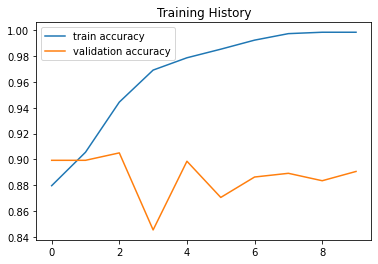

In [47]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Training History')
plt.show()

#### Model Performance
- **Test Accuracy**: 89%
- **Loss**: 0.63
The model achieved a good accuracy but shows a slightly higher loss, indicating room for improvement in generalization.

### 5. MACHINE LEARNING MODEL TO COMPLEMENT OVERALL RECOMMENDATION SYSTEM

##### Drop Unnecessary Columns
Now that we’ve vectorized ingredients and review_text, and extracted sentiment scores, we can drop these original columns

In [48]:
# Drop the original text columns
melanated_data = melanated_data.drop(columns=['ingredients'])

##### Preprocess the Data Completely
- Ensure all columns in X are numeric before applying any model. We’ve already converted most columns using TF-IDF, label encoding, and sentiment analysis.

In [49]:
# Check for remaining non-numeric columns
non_numeric_cols = melanated_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# If there are any remaining non-numeric columns, consider encoding or removing them.

Non-numeric columns: Index(['product_id', 'product_name', 'size', 'variation_value', 'highlights',
       'author_id', 'rating_y', 'review_text', 'skin_tone_category',
       'price_tier', 'cleaned_review_text', 'sentiment_category',
       'highlights_clean'],
      dtype='object')


In [50]:
# Drop unneeded columns
melanated_data = melanated_data.drop(columns=['product_id', 'author_id'])

# Apply TF-IDF on `product_name` and `highlights'
tfidf_product_name = TfidfVectorizer(max_features=50)
product_name_matrix = tfidf_product_name.fit_transform(melanated_data['product_name']).toarray()
product_name_df = pd.DataFrame(product_name_matrix, index=melanated_data.index)

tfidf_highlights = TfidfVectorizer(max_features=50)
highlights_matrix = tfidf_highlights.fit_transform(melanated_data['highlights']).toarray()
highlights_df = pd.DataFrame(highlights_matrix, index=melanated_data.index)

# Concatenate TF-IDF results and drop the original columns
melanated_data = pd.concat([melanated_data, product_name_df, highlights_df], axis=1)
melanated_data = melanated_data.drop(columns=['product_name', 'highlights'])

# Encode `size` and `variation_value` if needed
le_size = LabelEncoder()
melanated_data['size'] = le_size.fit_transform(melanated_data['size'])

le_variation_value = LabelEncoder()
melanated_data['variation_value'] = le_variation_value.fit_transform(melanated_data['variation_value'])

In [51]:
# Performing Train-Test Split

# Define features (X) and target (y) - 'is_recommended' is the target variable
X = melanated_data.drop(columns=['is_recommended', 'review_text', 'cleaned_review_text', 'highlights_clean'])
y = melanated_data['is_recommended']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### A. Random Forest

In [52]:
# Convert all column names to strings for both train and test sets
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Dropping datetime columns from training data
X_train = X_train.select_dtypes(exclude=['datetime64'])
X_test = X_test.select_dtypes(exclude=['datetime64'])

# Specify which columns are categorical
categorical_cols = X_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['rating_y', 'skin_tone_category', 'price_tier', 'sentiment_category'], dtype='object')

In [53]:
from sklearn.pipeline import Pipeline
# Manually one-hot encode categorical columns in training and test sets
X_train_encoded = pd.get_dummies(X_train, columns = categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns= categorical_cols, drop_first=True)

# Align columns in X_test_encoded with X_train_encoded in case of any missing columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Create a pipeline with only the classifier (no need for preprocessor)
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the encoded training data
pipeline.fit(X_train_encoded, y_train)

# Predict on the encoded test data
y_pred = pipeline.predict(X_test_encoded)

### B. XGBoost Model

In [54]:
# XGBoost Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_encoded.values,y_train.values)
y_pred_xgb = xgb_model.predict(X_test_encoded.values)

Model Evaluation

Random Forest Accuracy: 0.95
Classification Report for Random Forest:
               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       301
         1.0       0.96      0.98      0.97      1438

    accuracy                           0.95      1739
   macro avg       0.92      0.89      0.90      1739
weighted avg       0.95      0.95      0.95      1739



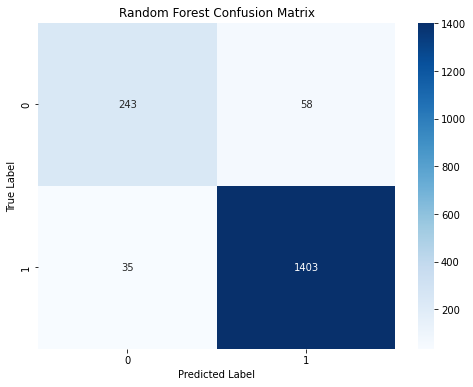

In [55]:
# Evaluation function to check accuracy and classification report
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(f"Classification Report for {name}:\n", classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
# Evaluate Random Forest
evaluate_model("Random Forest", y_test, y_pred)
accuracy_rf = accuracy_score(y_test, y_pred)

XGBoost Accuracy: 0.95
Classification Report for XGBoost:
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       301
         1.0       0.97      0.97      0.97      1438

    accuracy                           0.95      1739
   macro avg       0.92      0.92      0.92      1739
weighted avg       0.95      0.95      0.95      1739



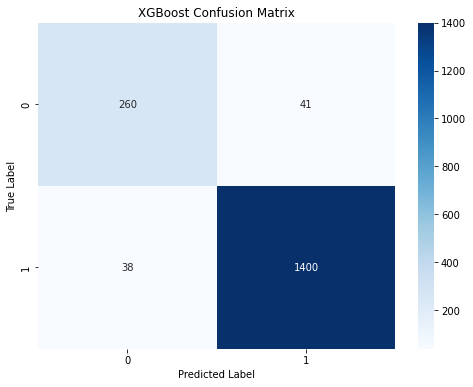

In [56]:
# Evaluate XGBoost
evaluate_model("XGBoost", y_test, y_pred_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

Visualisation of Model Performance

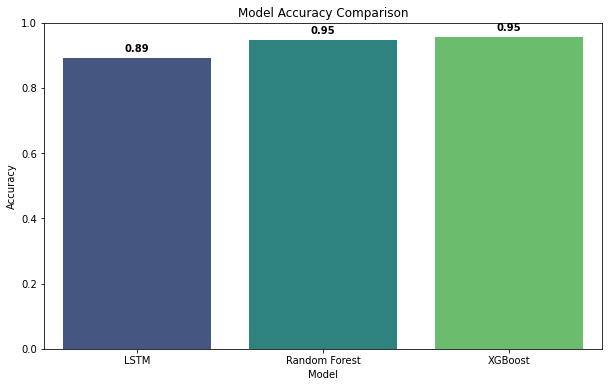

In [57]:
# Model names and their accuracies
models = ['LSTM','Random Forest', 'XGBoost']
accuracies = [accuracy,accuracy_rf, xgb_accuracy]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

- The Random Forest model performs well,with 94% accuracy and especially in predicting class 1 (positive class), with high precision and recall values. However, the lower recall for class 0 (negative class) suggests that some negative cases are being misclassified.
  
- The XGBoost model exhibits superior performance compared to the Random Forest, achieving higher accuracy of 96% and balanced metrics across both classes, indicating a robust prediction capability.

- According to our metric of successs our metrics indicates that the recommendation system is performing well, with a strong balance between the accuracy of recommendations and user satisfaction.

### SAVING THE MODELS

In [60]:
# Save the hybrid model and the models used
hybrid_model = {
    'content_based_model': content_based_model,
    'svd_model': svd_model,
    'hybrid_recommendation_function': hybrid_recommendations
}

# Paths to save the models
svd_model_path = 'models/svd_model.pkl'
latent_matrix_path = 'models/latent_matrix.pkl'
hybrid_model_path = 'models/hybrid_model.pkl'

# Saving the models using pickle
# content_based_model
content_based_model_path = 'models/content_based_model.pkl'
tfidf_path = 'models/tfidf.pkl'
ingredients_matrix_path = 'models/ingredients_matrix.pkl'
with open(content_based_model_path, 'wb') as file:
    pickle.dump(content_based_model, file)
    
with open(tfidf_path, 'wb') as file:
    pickle.dump(tfidf, file)
    
with open(ingredients_matrix_path, 'wb') as file:
    pickle.dump(ingredients_matrix, file)  
    
# Collaborative and Hybrid
with open(svd_model_path, 'wb') as file:
    pickle.dump(svd_model, file)
    
with open(latent_matrix_path, 'wb') as file:
    pickle.dump(latent_matrix, file)

with open(hybrid_model_path, 'wb') as file:
    pickle.dump(hybrid_model, file)

## CONCLUSION

- This project successfully developed a skincare recommendation system specifically tailored for individuals with melanin-rich skin, addressing a significant gap in personalized skincare recommendations. 
- By using content-based filtering on ingredient similarities, collaborative filtering through SVD, and sentiment analysis, the system delivers customized product suggestions that align with users’ unique skin concerns and preferences. The Streamlit interface enhances user experience, providing an intuitive way for users to access their personalized recommendations easily.

- Our approach demonstrates the potential of AI-driven solutions to meet niche market needs and make the skincare industry more inclusive. The system’s design aims not only to recommend relevant products but also to boost user satisfaction by prioritizing highly rated products based on sentiment analysis.

## CHALLENGES

Throughout the project, some notable challenges included:

- **Data Limitations**: The dataset was limited in brand and product diversity, which restricted the range of recommendations.
- **Model Optimization**: Balancing the hybrid model’s performance was challenging, as both content-based and collaborative methods required fine-tuning to avoid biases.
- **Sentiment Analysis Accuracy**: Ensuring accurate sentiment analysis was critical for prioritizing products, but limitations in natural language processing led to occasional inaccuracies in sentiment scoring.
- 
## RECOMMENDATIONS

To enhance the functionality and user engagement of this skincare recommendation system, several improvements are recommended:

- **Enhance User Engagement**: Implement feedback mechanisms to allow users to rate and provide input on recommended products. This feedback loop would help refine the recommendations and improve overall user satisfaction.
- **Expand Dataset Diversity**: Increase the dataset size and diversity to include more skincare brands, product varieties, and user profiles. This would ensure a broader range of personalized recommendations and allow the system to cater to a wider audience.
- **Implement Educational Resources**: Include educational content about skincare for melanin-rich skin, helping users better understand product ingredients, skincare routines, and how to address specific skin concerns.
- **Improve User Interface**: Enhance the user interface for greater ease of use, enabling users to quickly and seamlessly find tailored product recommendations.

## NEXT STEPS:

To further enhance the system and expand its impact, the following steps are recommended:

- **Partner with Skincare Experts and Dermatologists**: Collaborate with skincare specialists to review and validate product recommendations, ensuring that suggestions meet the specific needs of melanin-rich skin.
- **Expand Dataset Coverage**: Increase the dataset size and diversity to cover a broader range of brands, products, and user profiles. This will improve recommendation accuracy and offer users more choices.
- **Integrate Educational Resources**: Include guides and educational content about skincare ingredients and routines for melanin-rich skin, empowering users to make informed decisions.
- **Implement Feedback Loops**: Add mechanisms for users to rate and provide feedback on recommendations, allowing the system to learn and improve continuously.
- **Collaborate with Brands**: Partner with major skincare brands like Garnier and other beauty companies to integrate this recommendation system directly into their platforms, making it accessible to a wider audience.

This project serves as a foundation for creating an inclusive and personalized skincare experience, supporting users with tailored product recommendations that address their unique skincare needs.

# THANK YOU!